# Fiddler Simple Monitoring Quick Start Guide

Fiddler is the pioneer in enterprise Model Performance Management (MPM), offering a unified platform that enables Data Science, MLOps, Risk, Compliance, Analytics, and other LOB teams to **monitor, explain, analyze, and improve ML deployments at enterprise scale**. 
Obtain contextual insights at any stage of the ML lifecycle, improve predictions, increase transparency and fairness, and optimize business revenue.

---

You can start using Fiddler ***in minutes*** by following these 7 quick steps:

1. Imports
2. Connect to Fiddler
3. Upload a baseline dataset
4. Add metadata about your model with Fiddler
5. Set up Alerts and Notifications (Optional)
6. Publish production events
7. Get insights

**Don't have a Fiddler account? [Sign-up for a 14-day free trial](https://www.fiddler.ai/trial?utm_source=fiddler_docs&utm_medium=referral).**

## 1. Imports

In [ ]:
!pip install -q fiddler-client

import numpy as np
import pandas as pd
import time as time
import fiddler as fdl

print(f"Running client version {fdl.__version__}")

## 2. Connect to Fiddler

Before you can add information about your model with Fiddler, you'll need to connect using our API client.


---


**We need a few pieces of information to get started.**
1. The URL you're using to connect to Fiddler

In [ ]:
URL = '' # Make sure to include the full URL (including https://). For example, https://abc.xyz.ai

2. Your organization ID
3. Your authorization token

Both of these can be found by clicking the URL you entered and navigating to the **Settings** page of your Fiddler environment.

In [ ]:
ORG_ID = ''
AUTH_TOKEN = ''

Now just run the following to connect the client to your Fiddler environment.

In [ ]:
client = fdl.FiddlerApi(
    url=URL, 
    org_id=ORG_ID, 
    auth_token=AUTH_TOKEN
)

Once you connect, you can create a new project by specifying a unique project ID in the client's `create_project` function.

In [ ]:
PROJECT_ID = 'quickstart_example'

client.create_project(PROJECT_ID)

You should now be able to see the newly created project on the UI.

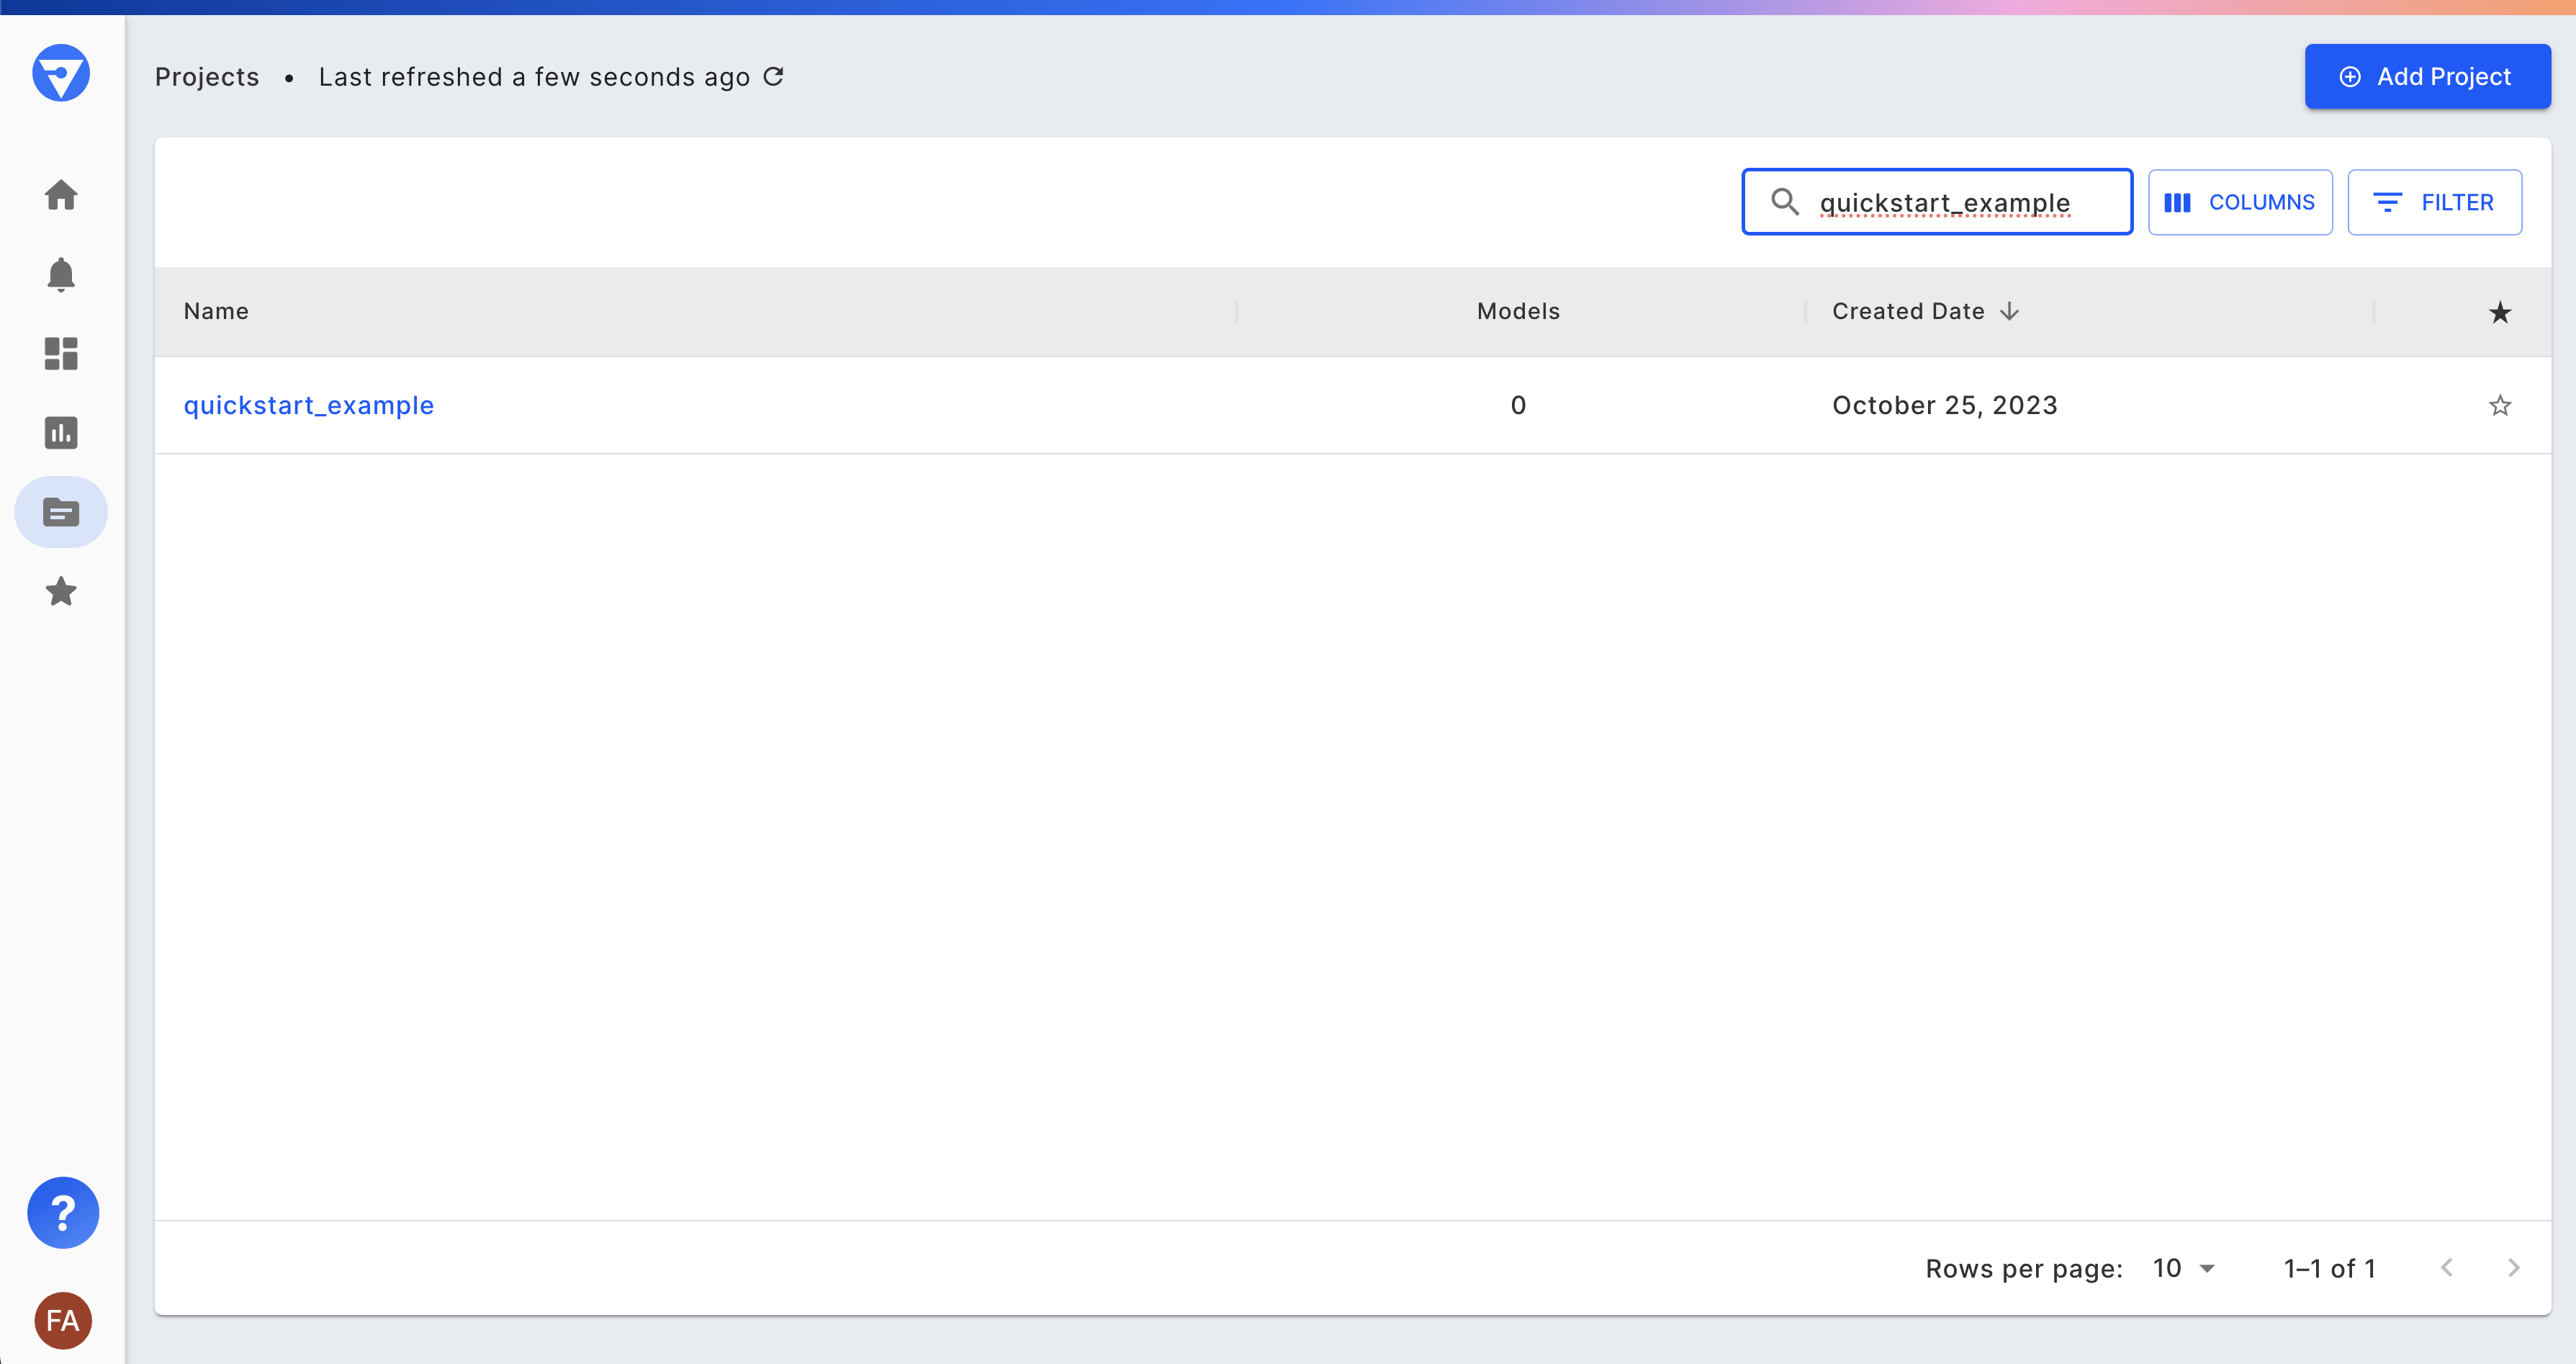

## 3. Upload a baseline dataset

In this example, we'll be considering the case where we're a bank and we have **a model that predicts churn for our customers**.  
We want to know when our model's predictions start to drift—that is, **when churn starts to increase** within our customer base.
  
In order to get insights into the model's performance, **Fiddler needs a small  sample of data that can serve as a baseline** for making comparisons with data in production.


---


*For more information on how to design a baseline dataset, [click here](https://docs.fiddler.ai/docs/designing-a-baseline-dataset).*

In [ ]:
PATH_TO_BASELINE_CSV = 'https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/churn_baseline.csv'

baseline_df = pd.read_csv(PATH_TO_BASELINE_CSV)
baseline_df

Fiddler uses this baseline dataset to keep track of important information about your data.
  
This includes **data types**, **data ranges**, and **unique values** for categorical variables.

---

You can construct a `DatasetInfo` object to be used as **a schema for keeping track of this information** by running the following code block.

In [ ]:
dataset_info = fdl.DatasetInfo.from_dataframe(baseline_df, max_inferred_cardinality=100)
dataset_info

Then use the client's [upload_dataset](https://docs.fiddler.ai/reference/clientupload_dataset) function to send this information to Fiddler!
  
*Just include:*
1. A unique dataset ID
2. The baseline dataset as a pandas DataFrame
3. The [DatasetInfo](https://docs.fiddler.ai/reference/fdldatasetinfo) object you just created

In [ ]:
DATASET_ID = 'churn_data'

client.upload_dataset(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    dataset={
        'baseline': baseline_df
    },
    info=dataset_info
)

If you click on your project in the Fiddler UI, you should now be able to see the newly onboarded dataset.

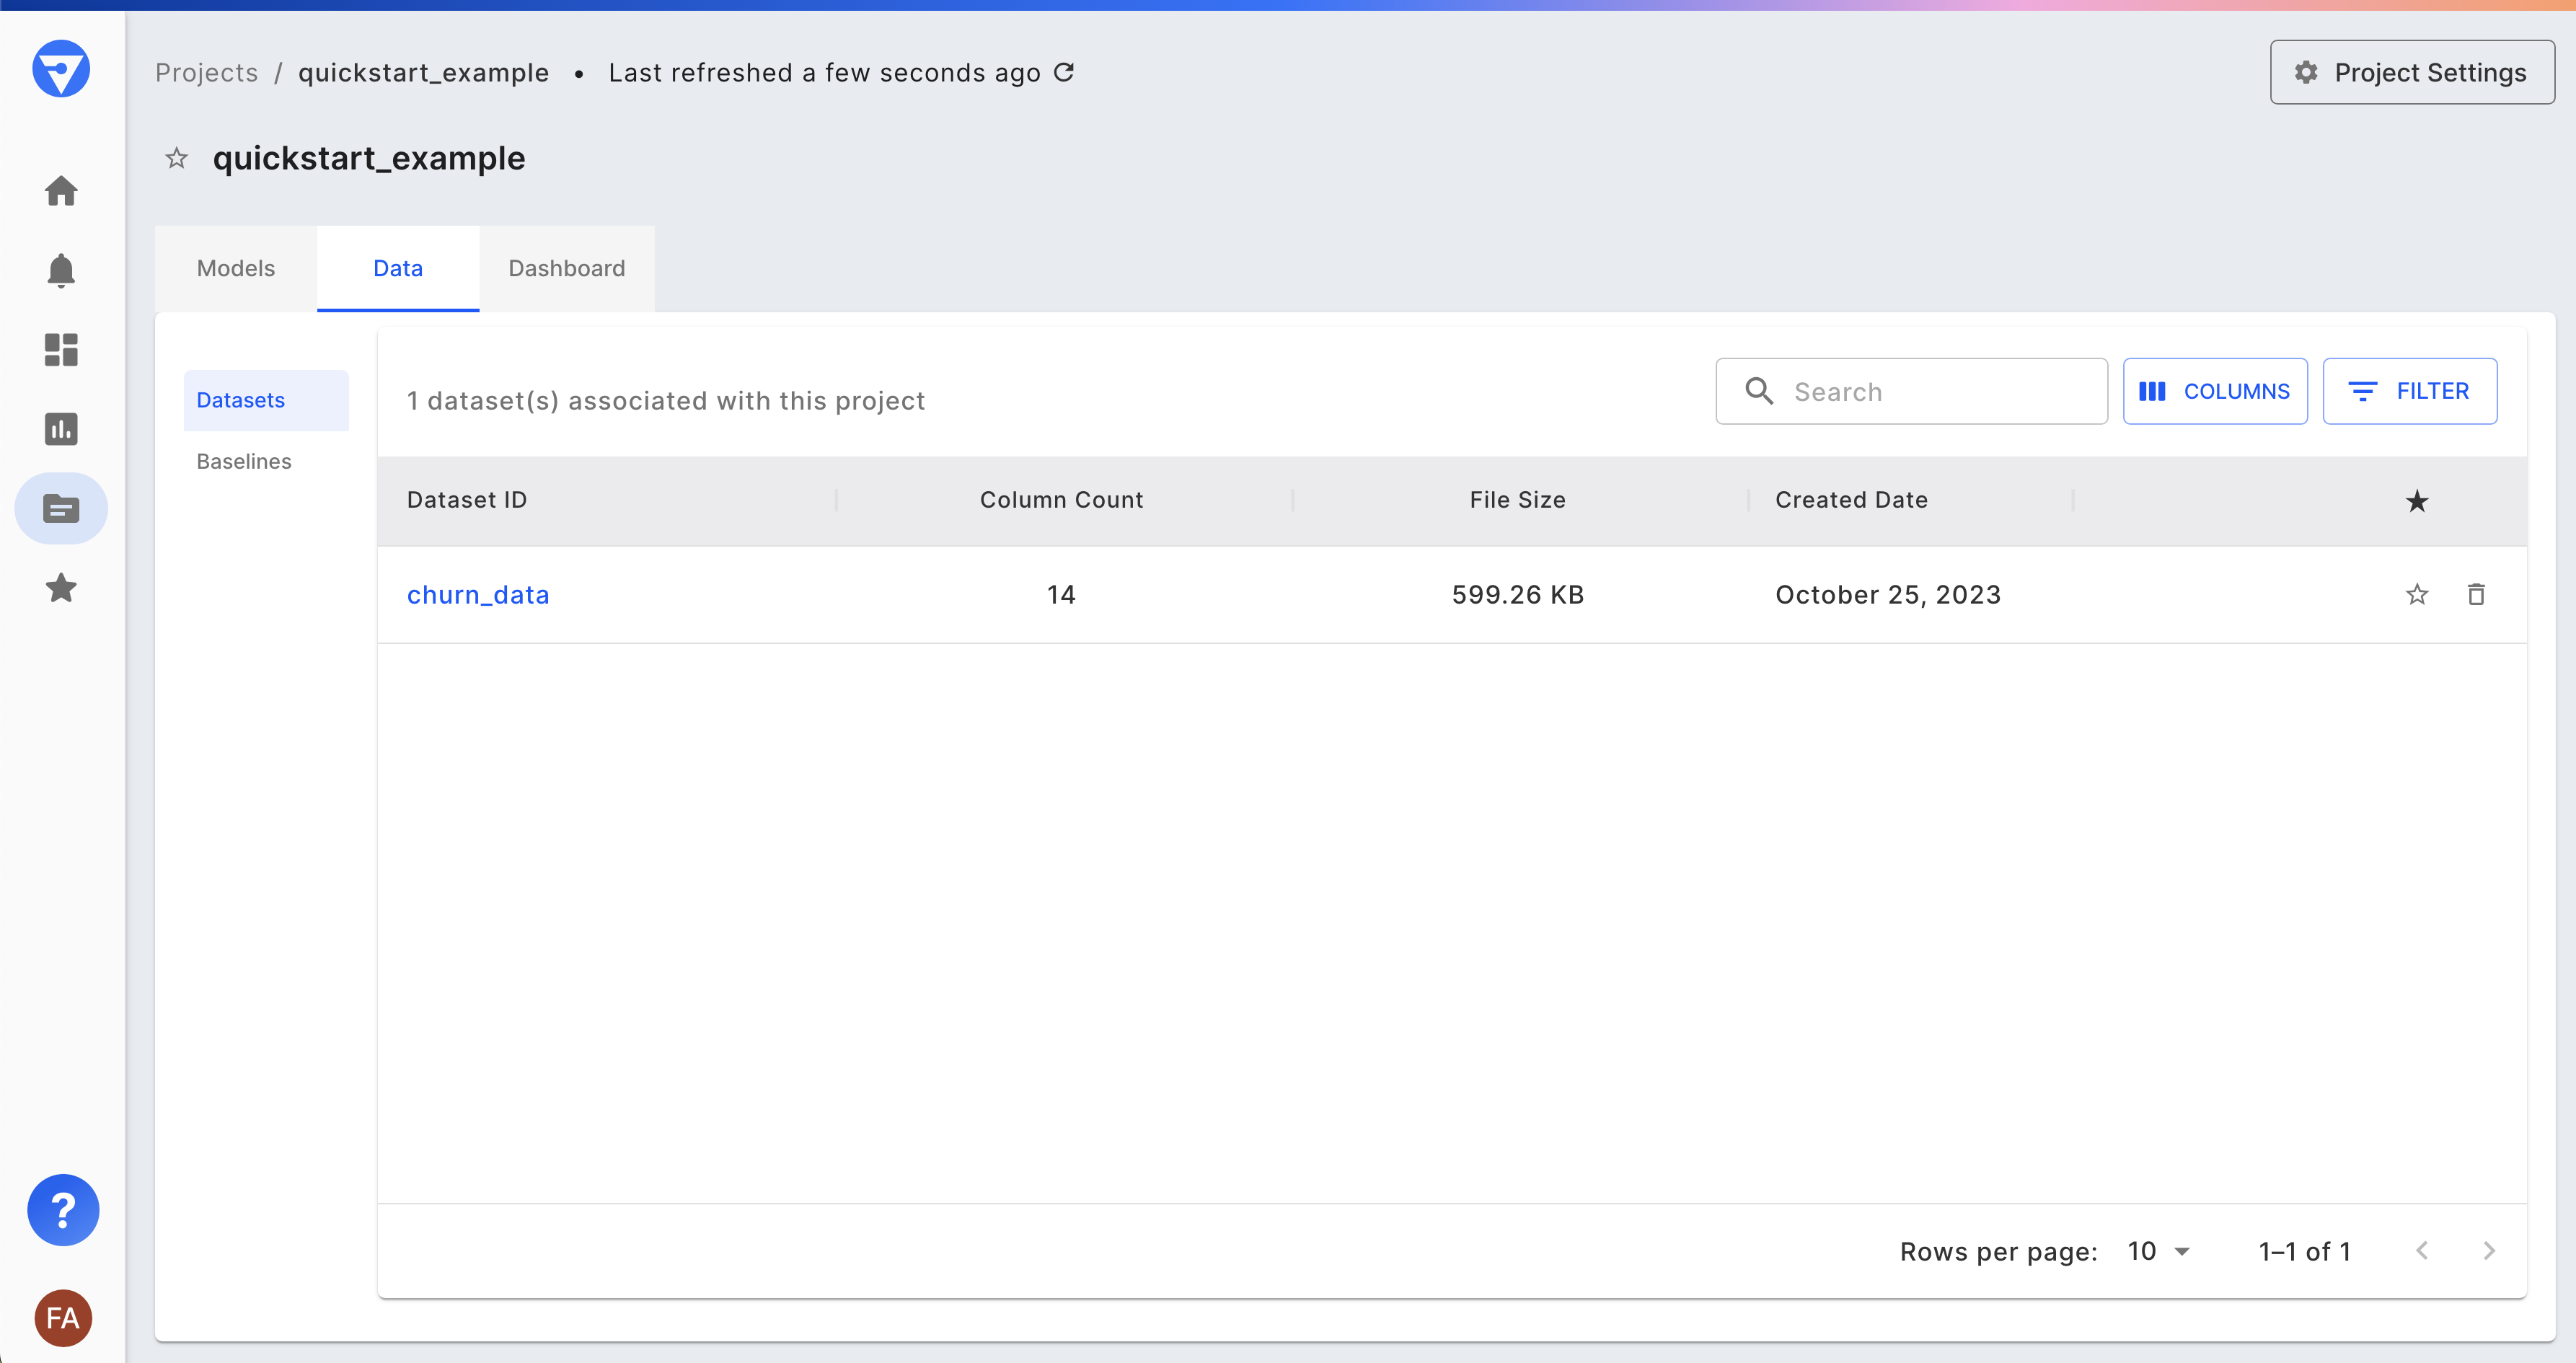

## 4. Add metadata about your model

Now it's time to add your model with Fiddler.  We do this by defining a [ModelInfo](https://docs.fiddler.ai/reference/fdlmodelinfo) object.


---


The [ModelInfo](https://docs.fiddler.ai/reference/fdlmodelinfo) object will contain some **information about how your model operates**.
  
*Just include:*
1. The **task** your model is performing (regression, binary classification, etc.)
2. The **target** (ground truth) column
3. The **output** (prediction) column
4. The **feature** columns
5. Any **metadata** columns
6. Any **decision** columns (these measures the direct business decisions made as result of the model's prediction)


In [ ]:
# Specify task
model_task = 'binary'

if model_task == 'regression':
    model_task = fdl.ModelTask.REGRESSION
    
elif model_task == 'binary':
    model_task = fdl.ModelTask.BINARY_CLASSIFICATION

elif model_task == 'multiclass':
    model_task = fdl.ModelTask.MULTICLASS_CLASSIFICATION
    
elif model_task == 'ranking':
    model_task = fdl.ModelTask.RANKING

    
# Specify column types
features = ['geography', 'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']
outputs = ['predicted_churn']
target = 'churn'
decision_cols = ['decision']
metadata_cols = ['customer_id']
    
# Generate ModelInfo
model_info = fdl.ModelInfo.from_dataset_info(
    dataset_info=dataset_info,
    dataset_id=DATASET_ID,
    model_task=model_task,
    features=features,
    outputs=outputs,
    target=target,
    categorical_target_class_details='yes',
    decision_cols=decision_cols, # Optional
    metadata_cols=metadata_cols, # Optional
    binary_classification_threshold=0.5 # Optional
)
model_info

Almost done! Now just specify a unique model ID and use the client's [add_model](https://docs.fiddler.ai/reference/clientadd_model) function to send this information to Fiddler.

In [ ]:
MODEL_ID = 'churn_classifier'

client.add_model(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    model_id=MODEL_ID,
    model_info=model_info,
)

On the project page, you should now be able to see the newly onboarded model with its model schema.

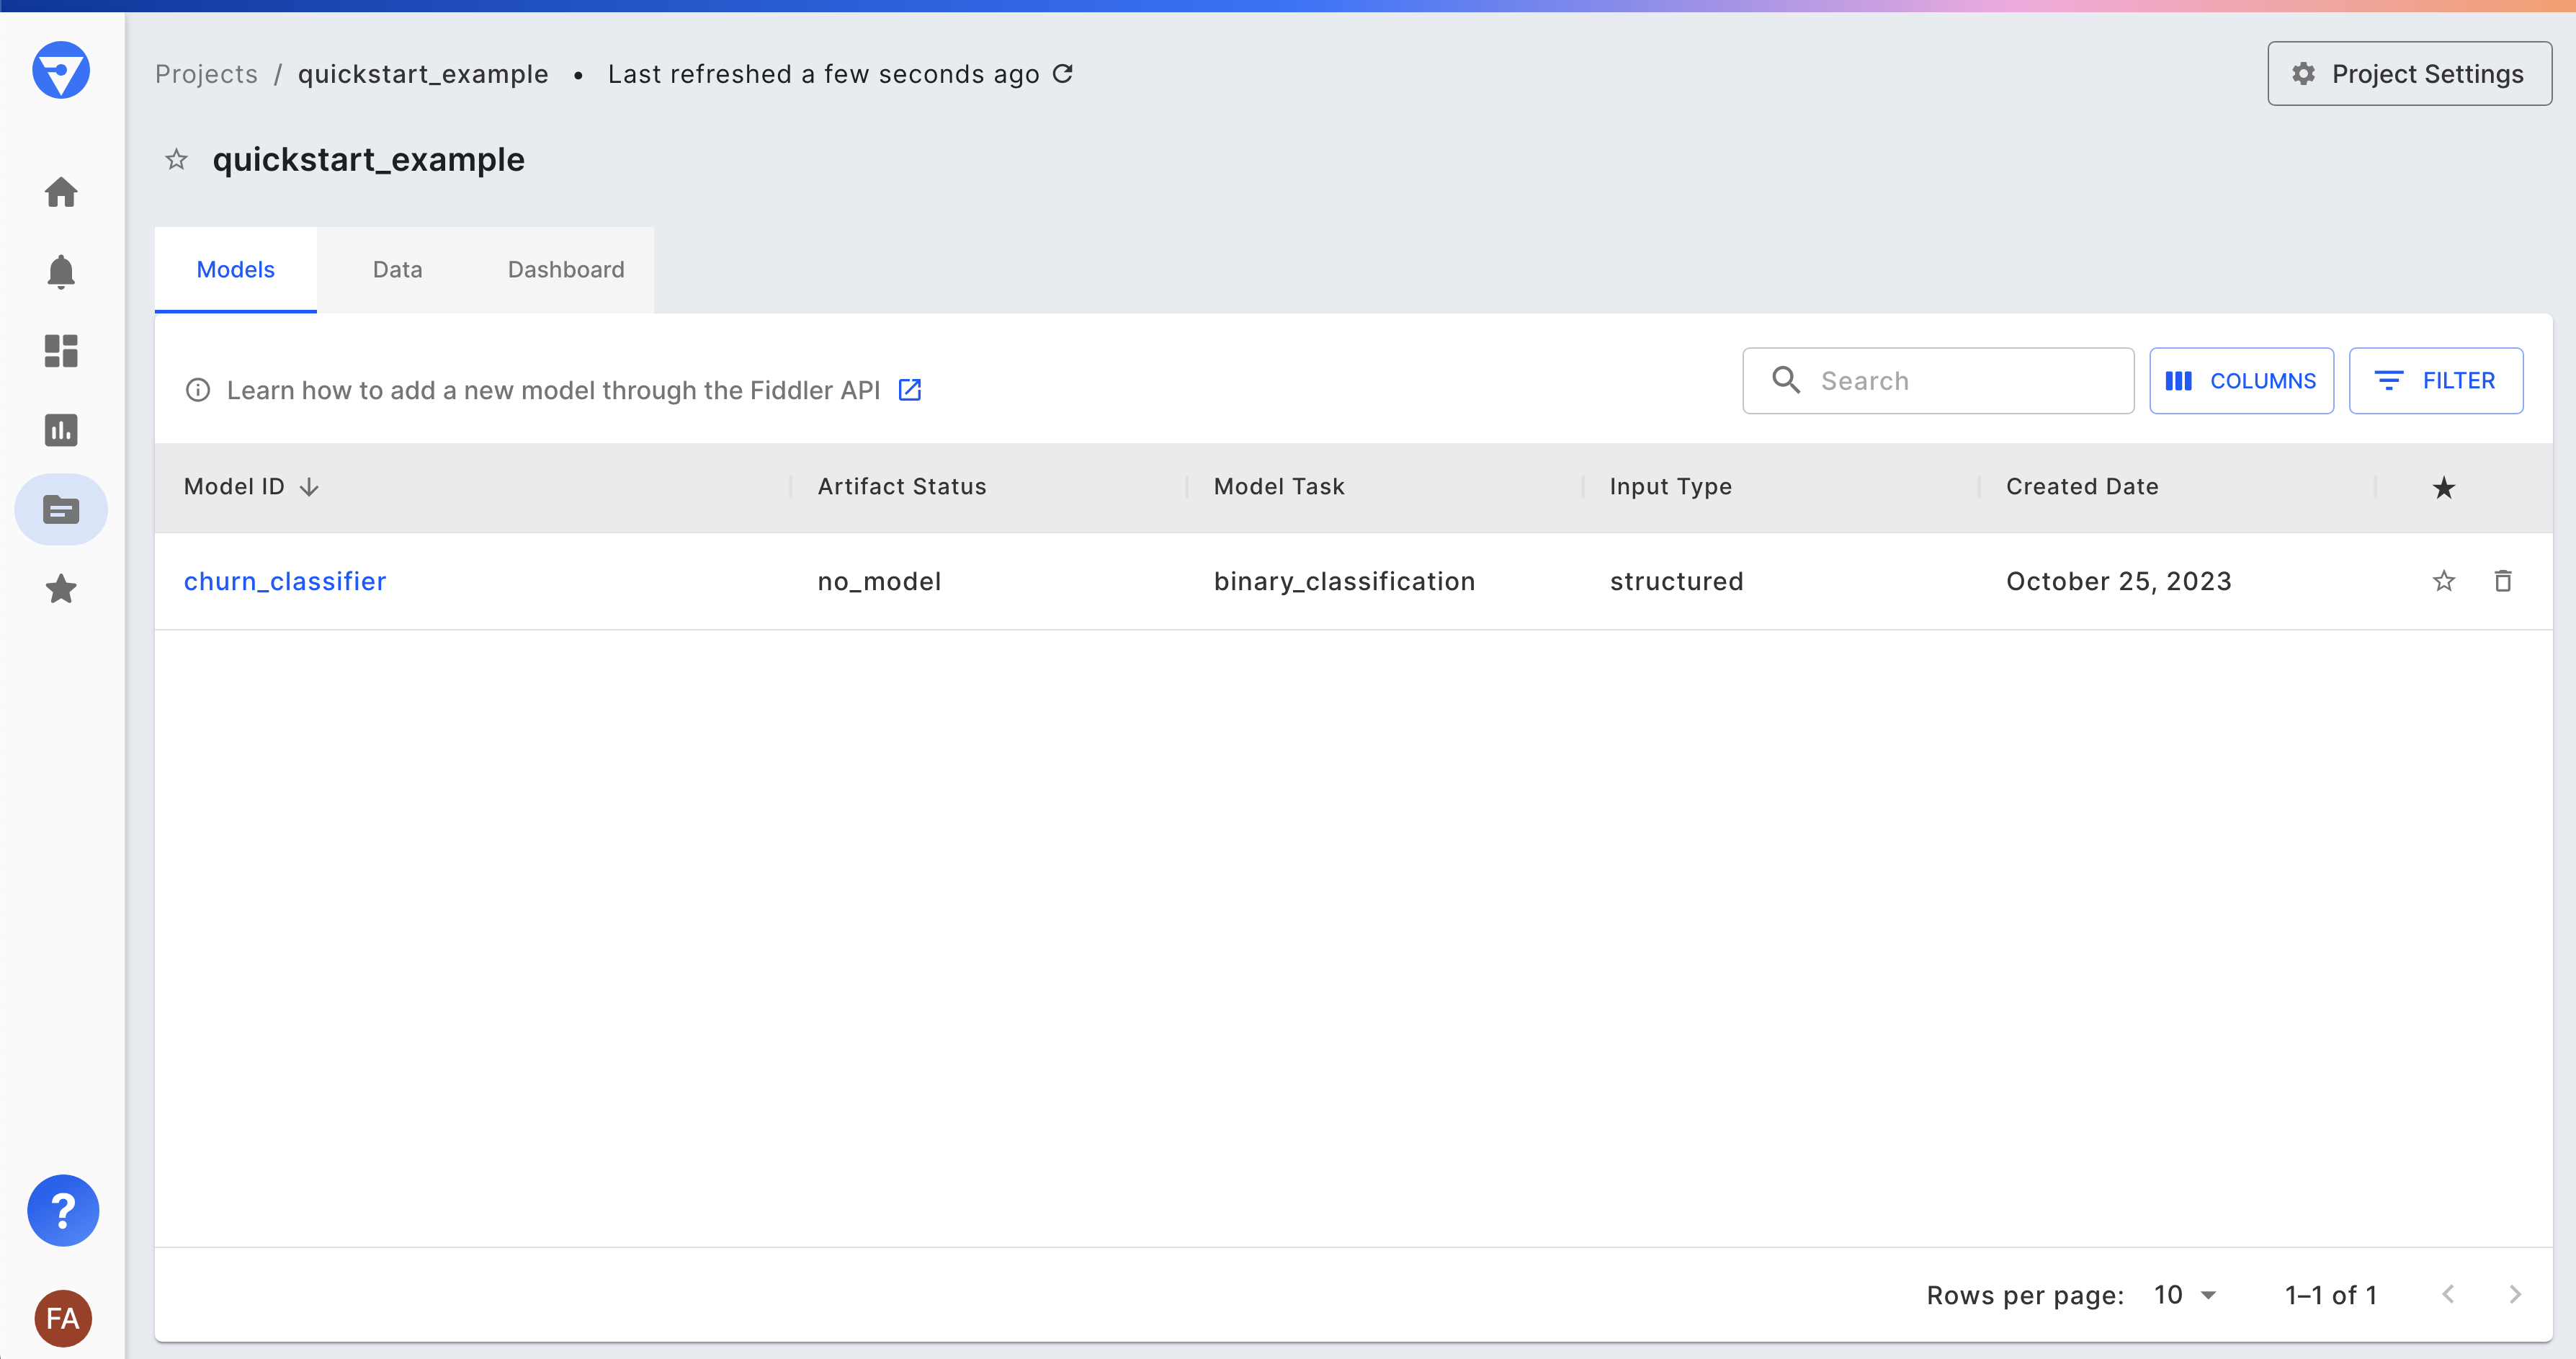

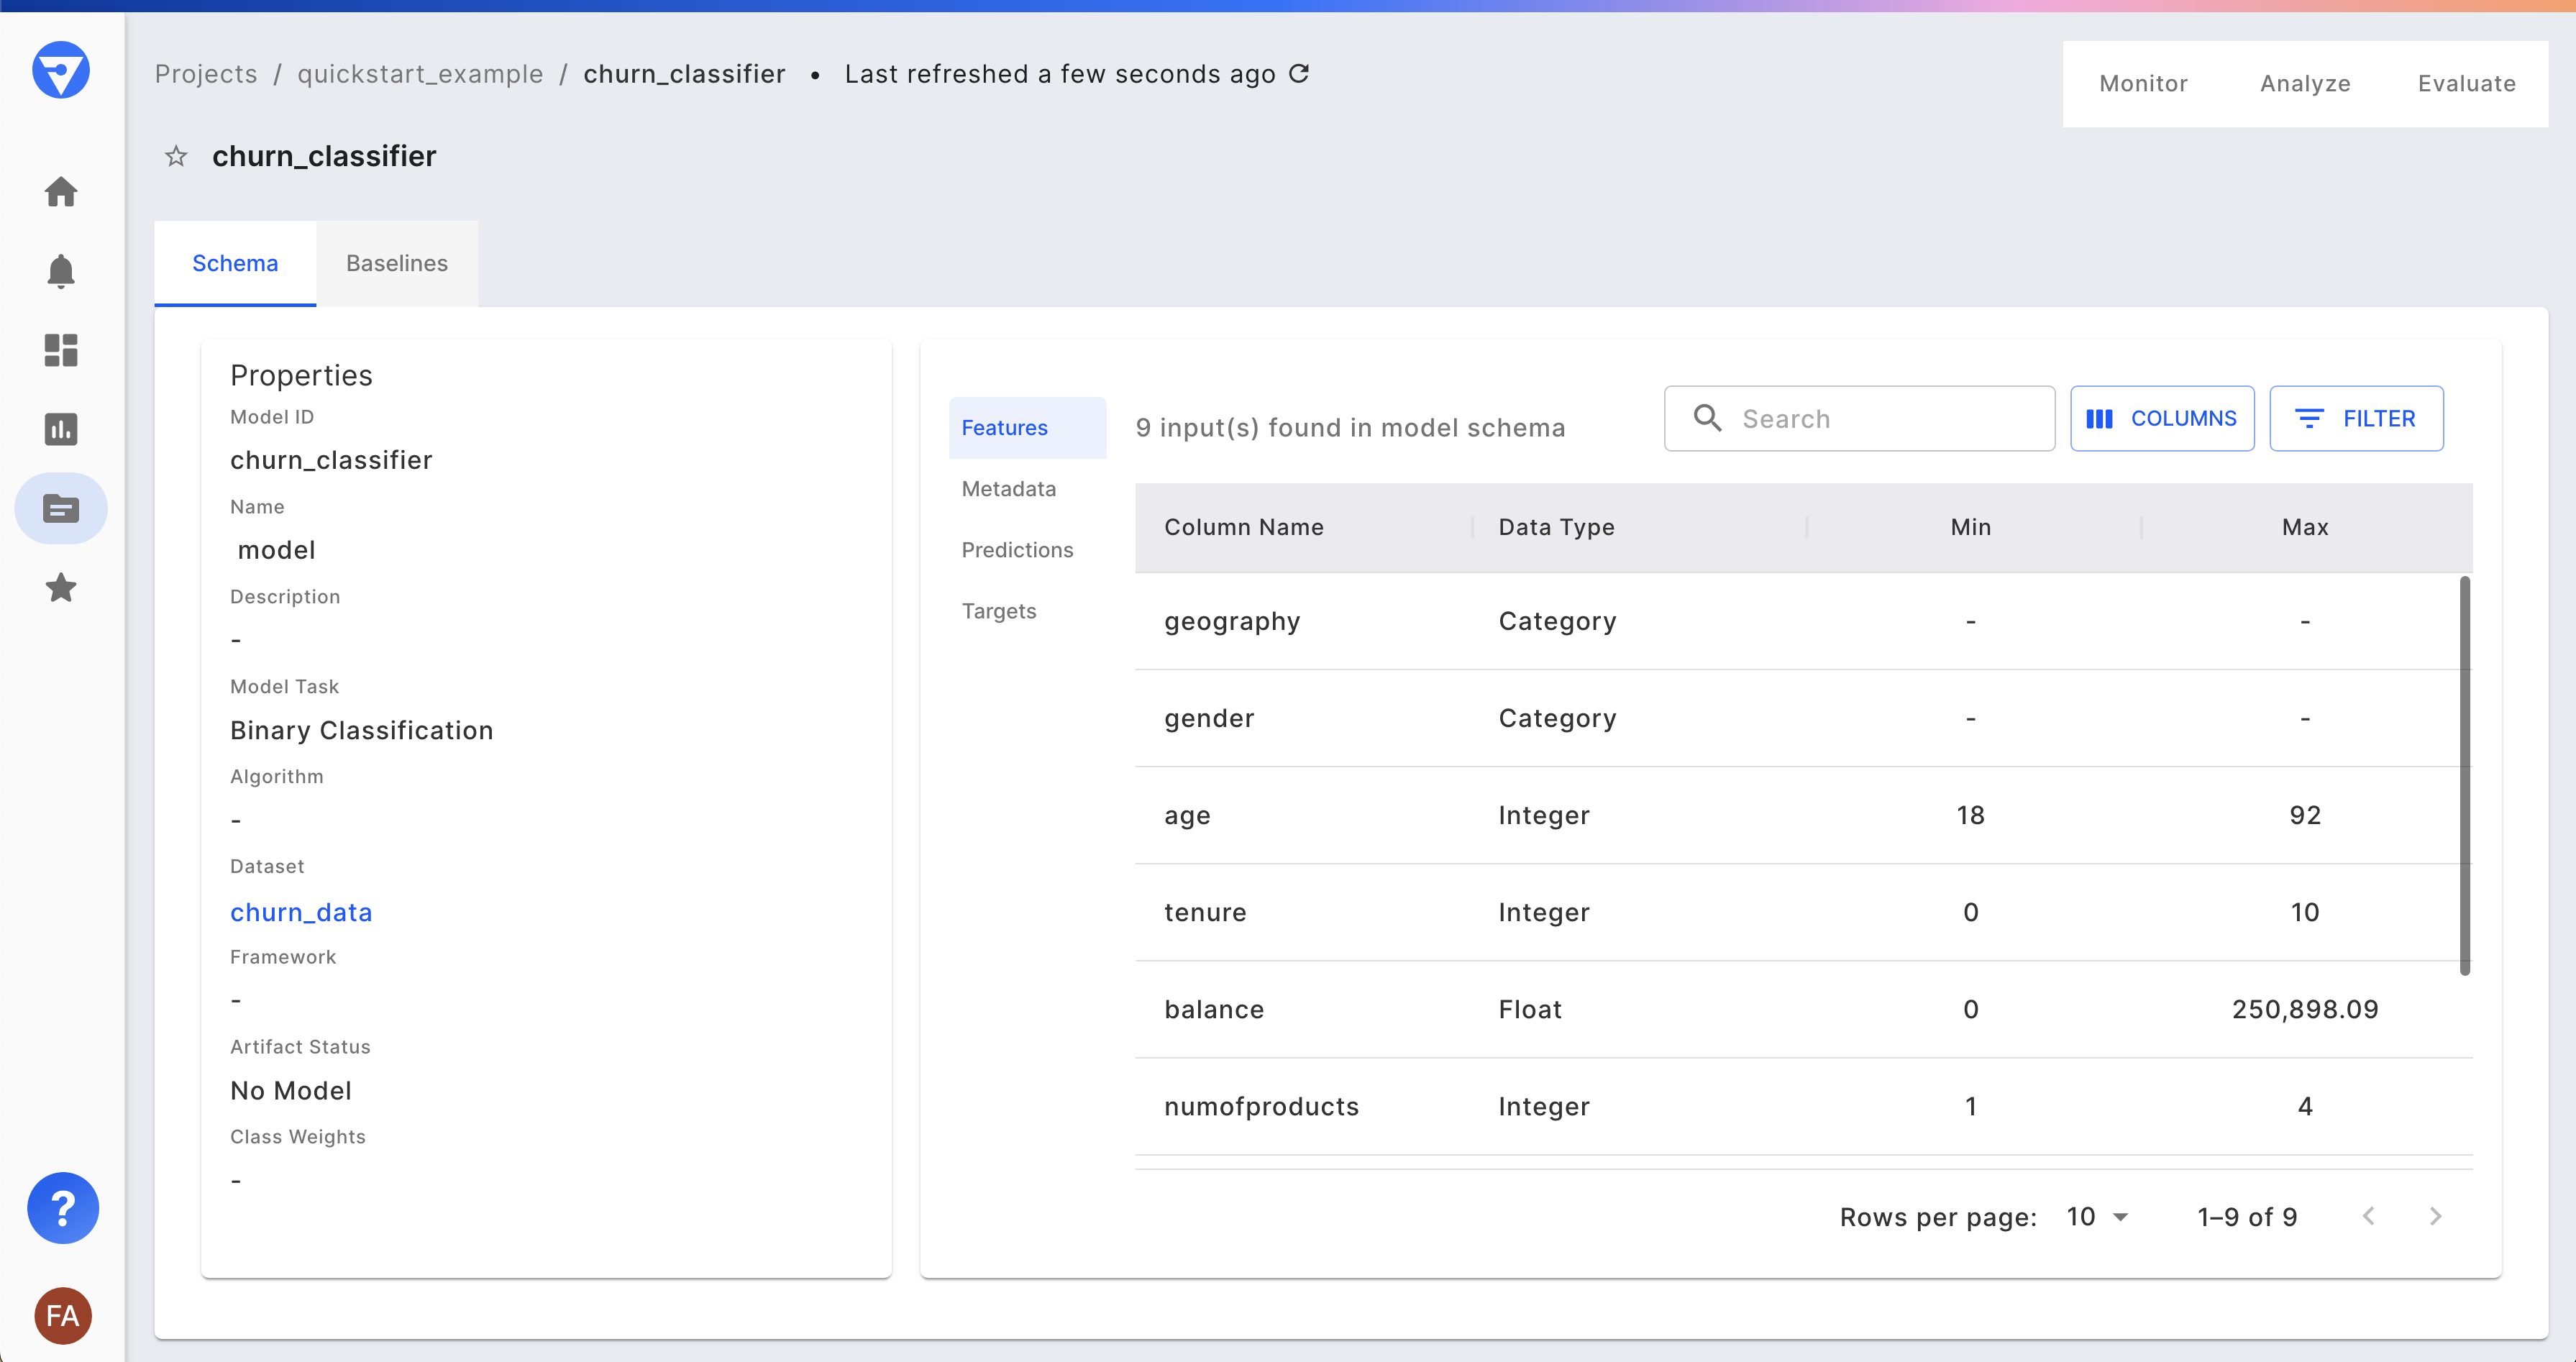

## 5. Set up Alerts and Notifications (Optional)

Fiddler Client API function [add_alert_rule](https://dash.readme.com/project/fiddler/v1.5/refs/clientadd_alert_rule) allow creating rules to receive email and pagerduty notifications when your data or model predictions deviates from it's expected behavior.

The rules can of **Data Drift, Performance, Data Integrity,** and **Service Metrics** types and they can be compared to **absolute** or **relative** values.

Please refer [our documentation](https://docs.fiddler.ai/docs/alerts) for more information on Alert Rules. 

---
  
Let's set up a few Alert Rules.

The following API call sets up a Data Integrity type rule which triggers an email notification when published events have 2 or more range violations in any 1 day bin for the ```numofproducts``` column.

In [ ]:
notifications_config = client.build_notifications_config(
    emails = "name@google.com",
)

client.add_alert_rule(
    name = "Bank Churn Range Violation Alert1",
    project_id = PROJECT_ID,
    model_id = MODEL_ID,
    alert_type = fdl.AlertType.DATA_INTEGRITY,
    metric = fdl.Metric.RANGE_VIOLATION,
    bin_size = fdl.BinSize.ONE_DAY, 
    compare_to = fdl.CompareTo.RAW_VALUE,
    #compare_period = None,
    priority = fdl.Priority.HIGH,
    warning_threshold = 2,
    critical_threshold = 3,
    condition = fdl.AlertCondition.GREATER,
    column = "numofproducts",
    notifications_config = notifications_config
)

The following API call sets up a Performance type rule which triggers an email notification when precision metric is 5% higher than that from 1 hr bin one day ago.

In [ ]:
notifications_config = client.build_notifications_config(
    emails = "name@google.com",
)
client.add_alert_rule(
    name = "Bank Churn Performance Alert",
    project_id = PROJECT_ID,
    model_id = MODEL_ID,
    alert_type = fdl.AlertType.PERFORMANCE,
    metric = fdl.Metric.PRECISION,
    bin_size = fdl.BinSize.ONE_HOUR, 
    compare_to = fdl.CompareTo.TIME_PERIOD,
    compare_period = fdl.ComparePeriod.ONE_DAY,
    warning_threshold = 0.05,
    critical_threshold = 0.1,
    condition = fdl.AlertCondition.GREATER,
    priority = fdl.Priority.HIGH,
    notifications_config = notifications_config
)

## 6. Publish production events

Information about your model is added to Fiddler and now it's time to start publishing some production data!  
Fiddler will **monitor this data and compare it to your baseline to generate powerful insights into how your model is behaving**.


---


Each record sent to Fiddler is called **an event**.
  
Let's load in some sample events from a CSV file.

In [ ]:
PATH_TO_EVENTS_CSV = 'https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/churn_events.csv'

production_df = pd.read_csv(PATH_TO_EVENTS_CSV)

# Shift the timestamps of the production events to be as recent as today 
production_df['timestamp'] = production_df['timestamp'] + (int(time.time() * 1000) - production_df['timestamp'].max())

You can use the client's `publish_events_batch` function to start pumping data into Fiddler!
  
*Just include:*
1. The DataFrame containing your events
2. The name of the column containing event timestamps

In [ ]:
client.publish_events_batch(
    project_id=PROJECT_ID,
    model_id=MODEL_ID,
    batch_source=production_df,
    timestamp_field='timestamp',
    id_field='customer_id' # Optional
)

## 7. Get insights
  
Return to your Fiddler environment to get enhanced observability into your model's performance.

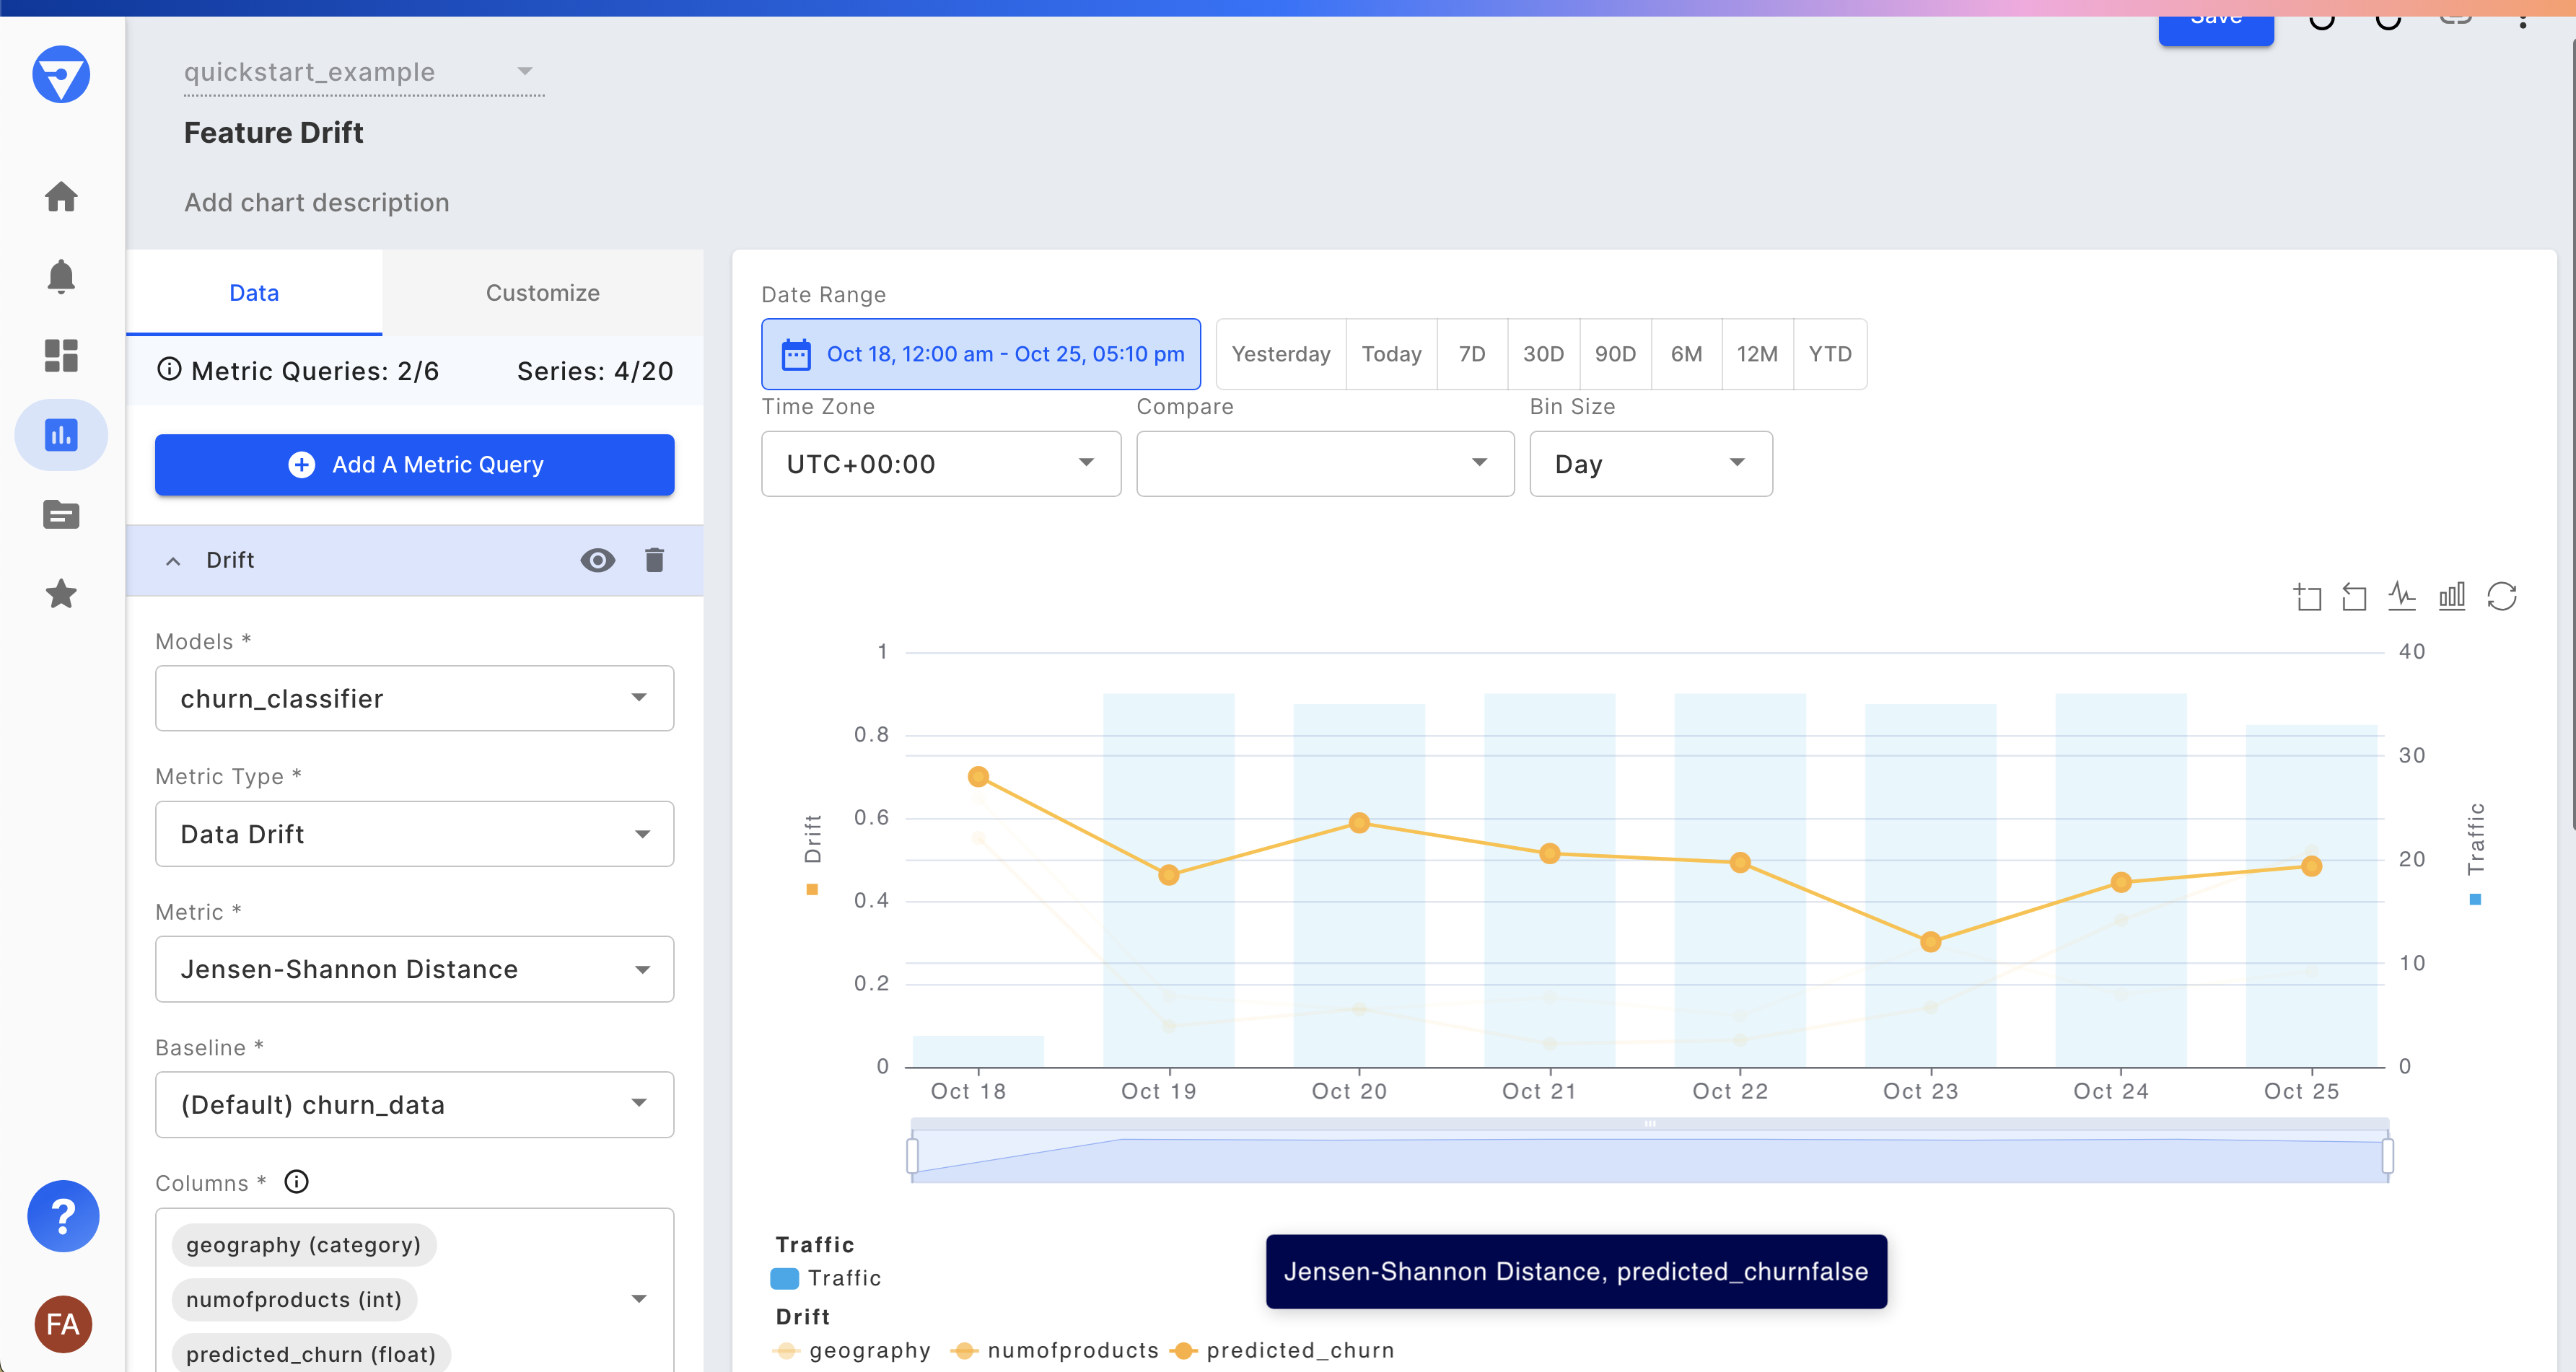

**What's Next?**

Try the [NLP Monitoring - Quickstart Notebook](https://docs.fiddler.ai/docs/simple-nlp-monitoring-quick-start)

---


**Questions?**  
  
Check out [our docs](https://docs.fiddler.ai/) for a more detailed explanation of what Fiddler has to offer.

Join our [community Slack](http://fiddler-community.slack.com/) to ask any questions!

If you're still looking for answers, fill out a ticket on [our support page](https://fiddlerlabs.zendesk.com/) and we'll get back to you shortly.